# 機械学習 手書き文字認識編

機械学習と一口に言っても様々なものがあります  
人工知能だったり、画像認識だったり、はたまたクラス分類だったり...  
今回はそのなかでも画像認識と分類を合わせた感じの部分をやっていきます  

## 用意するもの

・Python3  
Python2での実行は保証しません。今後のためにも是非Python3に移行してやってみて下さい  

・データセット  
http://www.cad.zju.edu.cn/home/dengcai/Data/MLData.html  
ここに用意されているUSPS.matをダウンロードして下さい  
MATLABは使わないので、ダウンロードしたデータは単純に実行したいディレクトリ内に移すようにして下さい  
以下の様なコードでデータを扱う事が出来ます

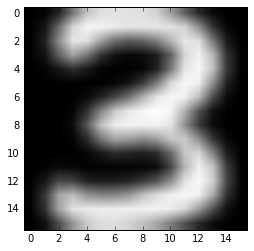

In [30]:
import numpy as np
import scipy as sp
import scipy.io
import matplotlib.pyplot as plt

#numpy.ndarrayオブジェクトとして格納される
#特徴量のデータ
fea_data = scipy.io.loadmat("./USPS.mat")['fea']
#ラベルのデータ
gnd_data = scipy.io.loadmat("./USPS.mat")['gnd']

#訓練データとそのラベル(id)
#以下の様に定義した時、train_dataは1706*256のデータを持つ事になる
#1つの行が1つの手書き数字の画像を表している
train_data = fea_data[1:1707,:]
train_id = gnd_data[1:1707]
#テストデータとそのラベル(id)
test_data = fea_data[7292:7292+2006,:]
test_id = gnd_data[7292:7292+2006]

#画像を表示する際は以下の通りに行列を整形し直して表示
plt.imshow(test_data[1,:].reshape((16,16)),cmap='Greys_r')


## 手始めに
まずは平均値による分類をやってみましょう。結構"分類"と"クラスタリング"を混同しがちですが、今回は"分類"に部類分けされます  
アバウトに言ってしまえば両者の違いは教師"あり"か"無し"かになります  
分類は、**特定の分け方を再現するモデルを作成するもの**  
クラスタリングは、**潜在する「集まり」を再現するもの**  
と思ってもらえれば良いです  

参考元 http://www.mindware-jp.com/basic/group.html  
        　　http://gihyo.jp/dev/serial/01/machine-learning/0015
          
以下のコードで平均値の分類を行えます。この時点で数学的知識はほとんど必要ありません。単純に機械学習、特に分類におけるPythonの使い方を覚えてくだされば十分です


In [97]:
import numpy as np
import scipy as sp
import scipy.io
import matplotlib.pyplot as plt

#numpy.ndarrayオブジェクトとして格納される
#特徴量のデータ
fea_data = scipy.io.loadmat("./USPS.mat")['fea']
#ラベルのデータ
gnd_data = scipy.io.loadmat("./USPS.mat")['gnd']

#訓練データとそのラベル(id)
train_data = fea_data[1:1707,:]
train_id = gnd_data[1:1707]
#テストデータとそのラベル(id)
test_data = fea_data[7292:7292+2006,:]
test_id = gnd_data[7292:7292+2006]

#ラベルごとの画像の平均をとった行列の作成
def img_average(train_data,train_id):
    A = np.zeros((10,256))
    id_len = train_id.size
    count = np.zeros((1,10))
    for s in range(id_len):
        pos = train_id[s]
        A[pos-1,:] += train_data[s,:]
        count[0][pos-1] += 1
    for t in range(10):
        A[t,:] = A[t,:]/count[0][t]
    return A

#最小二乗法(恐らく広義における最小二乗法)による分類
#分類に対する正解率を出力としている
def square_least(r_A,test_data,test_id):
    id_len = test_id.size
    diff = np.zeros((10,256))
    correct = 0
    for x in range(id_len):
        diff = np.linalg.norm(r_A[0,:] - test_data[x,:])
        num = 0
        for y in range(1,10):
            diff_v = np.linalg.norm(r_A[y,:] - test_data[x,:])
            if diff > diff_v:
                diff = diff_v
                num = y
        if test_id[x] == num+1:
            correct += 1
    return (correct/id_len)*100

result = img_average(train_data,train_id)
pca = square_least(result,test_data,test_id)
print(pca)

81.10667996011965


img_averageは、与えられた訓練データ(train_data)に与えられたラベル(train_id)に応じて訓練データを分けて格納する行列を作成し、それぞれの行をラベル数で割っています

square_leastは、恐らく正確な最小二乗法ではありませんが、行の差のノルムを取っているので最小二乗法として捉えて考えています  
今回は最小二乗法、すなわちノルムを最小にするようなラベルに分類していきましたが、分類の仕方は様々です  
例えば、各行をベクトルとして捉え、各行とテストデータのなす角が最小になるように取る手法も存在します(コサイン類似度)  
ただしその場合、正解率は少し落ちて80%付近になります  

出力されている正解率を見れば分かる通り、八割の正解率を出しているこの手法は悪くないように思えます。ですが、機械学習的にはまだ満足のいかない、まだ突き詰めなければならないと思う訳です  

## 性能の向上

という訳で、先程の正解率よりも更に正確であるような手法について考えて行きます  

### 主成分分析

機械学習に触れてみようとした人ならば一度や二度は聞いた事があるのではないでしょうか  
恐らくアヤメの分類における実験が一番有名なはずです(個人差あり)  
今回は、これを用いて先程のデータセットについて分類していきたいと思います  

## SVD
SVDとは、特異値分解の事です   
特異値分解とは、任意の$m \times n$行列に対して  
$ A = U \Sigma V $　  
となるような  
$m \times m$の直交行列$U$　  
$n \times n$の直交行列$V$  
$m \times n$の、対角成分に特異値を含む対角行列$\Sigma$  

In [23]:
import numpy as np
import scipy as sp
import scipy.io
import matplotlib.pyplot as plt

fea_data = scipy.io.loadmat("./USPS.mat")['fea']
gnd_data = scipy.io.loadmat("./USPS.mat")['gnd']

train_data = fea_data[1:1707,:]
train_id = gnd_data[1:1707]
test_data = fea_data[7292:7292+2006,:]
test_id = gnd_data[7292:7292+2006]

n = 6
find_num = [i for i, x in enumerate(train_id) if x == n]
temp = train_data[find_num[0],:]
for s in range(1,len(find_num)):
    temp = np.vstack((temp,train_data[find_num[s],:]))
A = temp.transpose()
U,s,V = np.linalg.svd(A)

plt.imshow(U[:,0].reshape((16,16)),cmap='Greys_r')